In [3]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt


def parse_gpsc(filepath):
    channels = []

    with open(filepath, 'r') as file:
        lines = file.readlines()

    for line in lines:
        parts = line.strip().split()
        if len(parts) < 4:
            continue

        name = parts[0]
        try:
            x, y, z = map(float, parts[1:4])
            channels.append((name, x, y, z))
        except ValueError:
            continue

    return channels

def plot_3d_interactive(channels):
    x = [ch[1] for ch in channels]
    y = [ch[2] for ch in channels]
    z = [ch[3] for ch in channels]
    labels = [ch[0] for ch in channels]

    fig = go.Figure()

    fig.add_trace(go.Scatter3d(
        x=x, y=y, z=z,
        mode='markers+text',
        text=labels,
        textposition='top center',
        marker=dict(
            size=5,
            color='blue',
            opacity=0.8
        )
    ))

    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        title='Interactive 3D EEG Channel Plot',
        margin=dict(l=0, r=0, b=0, t=40)
    )

    fig.show()

def plot_topdown(channels):
    """
    Plots the 2D top-down view (X vs Y) of EEG channels.
    """
    plt.figure(figsize=(8, 8))
    for name, x, y, z in channels:
        plt.plot(x, y, 'o', markersize=5)
        plt.text(x, y, name, fontsize=8, ha='center', va='center')

    plt.gca().invert_yaxis()  # Optional: invert Y to match top-down view
    plt.axis('equal')
    plt.title('Top-down View of EEG Channels')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.tight_layout()
    plt.show()



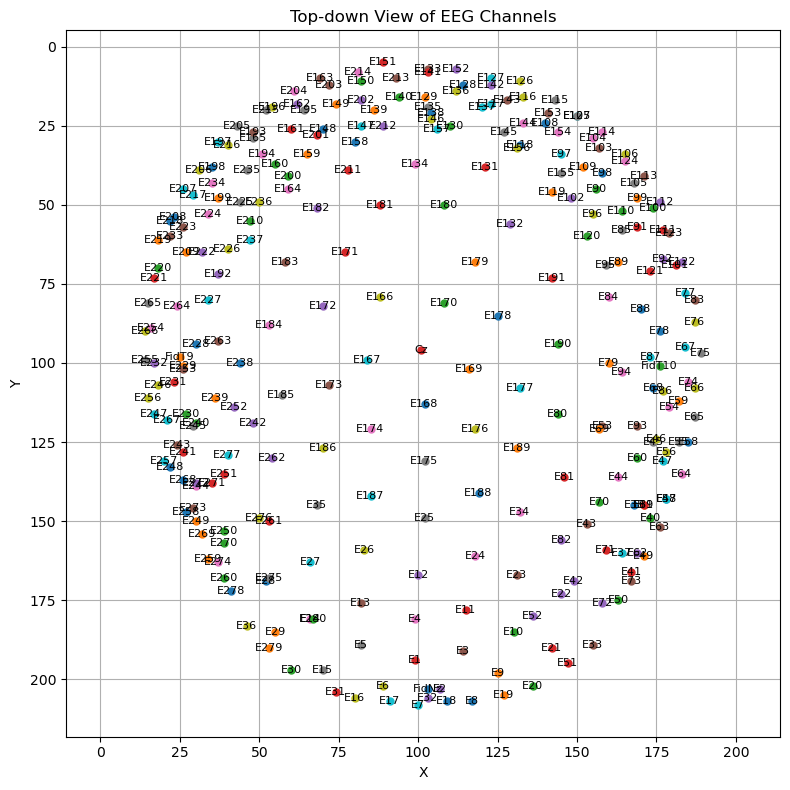

In [ ]:
file_path = "# %%
import plotly.graph_objects as go
import matplotlib.pyplot as plt


def parse_gpsc(filepath):
    channels = []

    with open(filepath, 'r') as file:
        lines = file.readlines()

    for line in lines:
        parts = line.strip().split()
        if len(parts) < 4:
            continue

        name = parts[0]
        try:
            x, y, z = map(float, parts[1:4])
            channels.append((name, x, y, z))
        except ValueError:
            continue

    return channels

def plot_3d_interactive(channels):
    x = [ch[1] for ch in channels]
    y = [ch[2] for ch in channels]
    z = [ch[3] for ch in channels]
    labels = [ch[0] for ch in channels]

    fig = go.Figure()

    fig.add_trace(go.Scatter3d(
        x=x, y=y, z=z,
        mode='markers+text',
        text=labels,
        textposition='top center',
        marker=dict(
            size=5,
            color='blue',
            opacity=0.8
        )
    ))

    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        title='Interactive 3D EEG Channel Plot',
        margin=dict(l=0, r=0, b=0, t=40)
    )

    fig.show()

def plot_topdown(channels):
    """
    Plots the 2D top-down view (X vs Y) of EEG channels.
    """
    plt.figure(figsize=(8, 8))
    for name, x, y, z in channels:
        plt.plot(x, y, 'o', markersize=5)
        plt.text(x, y, name, fontsize=8, ha='center', va='center')

    plt.gca().invert_yaxis()  # Optional: invert Y to match top-down view
    plt.axis('equal')
    plt.title('Top-down View of EEG Channels')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.tight_layout()
    plt.show()



# %%
file_path = "/home/jaizor/jaizor/xtra/data/ghw280_from_egig.gpsc"
channels = parse_gpsc(file_path)
plot_topdown(channels)


# %%
plot_3d_interactive(channels)



"
channels = parse_gpsc(file_path)
plot_topdown(channels)


In [5]:
plot_3d_interactive(channels)


In [ ]:
# ghw280_analyzer_enhanced.py
# Enhanced High-density EEG Channel Mapping for GHW280
# Fixes computational errors and improves visualization aesthetics

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import os
import numpy as np
import pandas as pd

# -------------------------------
# 1. Parse .gpsc file (unchanged)
# -------------------------------
def parse_gpsc(filepath):
    """Parse GHW280 .gpsc file: Label X Y Z"""
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"File not found: {filepath}")

    channels = []
    with open(filepath, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) < 4:
                continue
            name = parts[0]
            try:
                x, y, z = map(float, parts[1:4])
                channels.append((name, x, y, z))
            except ValueError:
                print(f"Warning: Could not parse {name}")
                continue
    print(f"Parsed {len(channels)} channels from {filepath}")
    return channels


# -------------------------------
# 2. FIXED: Assign Anatomical Regions & Rename Channels
# -------------------------------
def assign_regions_and_rename(channels):
    """
    FIXED VERSION: Use 3D coordinates to assign regions and rename channels
    """
    # Extract fiducials safely
    fiducials = {}
    ch_dict = {ch[0]: np.array(ch[1:]) for ch in channels}
    
    # Find fiducials with error handling
    for fid_name in ['FidNz', 'FidT9', 'FidT10', 'Cz']:
        if fid_name in ch_dict:
            fiducials[fid_name] = ch_dict[fid_name]
        else:
            print(f"Warning: {fid_name} not found in channels")
    
    if len(fiducials) < 3:
        print("Warning: Not enough fiducials found, using approximate values")
        # Use default anatomical coordinate system
        fnz = np.array([100, 200, 150])  # approximate nasion
        cz = np.array([100, 100, 250])   # approximate vertex
    else:
        fnz = fiducials.get('FidNz', np.array([100, 200, 150]))
        cz = fiducials.get('Cz', np.array([100, 100, 250]))
    
    # FIXED: Calculate anatomical axes properly
    # Y-axis typically points anterior (towards nose)
    # Z-axis typically points superior (towards top of head)
    # X-axis points right (ear to ear)
    
    # Calculate center of head coordinate system
    head_center = np.mean([pos for pos in ch_dict.values()], axis=0)
    
    # Initialize regions
    regions = {
        'Frontal': [], 'Central': [], 'Parietal': [], 'Occipital': [],
        'Temporal': [], 'Left': [], 'Right': [], 'Midline': [],
        'Mastoid': [], 'Periocular': [], 'Vertex': [], 'Other': []
    }
    
    mapping = {}
    
    for name, pos in ch_dict.items():
        x, y, z = pos
        
        # FIXED: Better laterality determination
        rel_x = x - head_center[0]  # Relative to head center
        is_left = rel_x < -15
        is_right = rel_x > 15
        is_midline = abs(rel_x) <= 15
        
        # FIXED: Better anterior-posterior determination
        rel_y = y - head_center[1]  # Relative to head center
        is_frontal = rel_y > 30      # Anterior
        is_central = -30 <= rel_y <= 30
        is_parietal = -60 <= rel_y < -30
        is_occipital = rel_y < -60   # Posterior
        
        # FIXED: Better superior-inferior determination
        rel_z = z - head_center[2]
        is_superior = rel_z > 20
        is_temporal = rel_z < -20 and abs(rel_x) > 40
        
        # Assign regions with improved logic
        if name.startswith('Fid'):
            # Handle fiducials
            if 'Nz' in name:
                mapping[name] = 'Nz'
            elif 'T9' in name:
                mapping[name] = 'A1'
            elif 'T10' in name:
                mapping[name] = 'A2'
            regions['Other'].append(name)
            continue
            
        # FIXED: EOG detection based on position near eyes
        eye_distance = np.linalg.norm(pos - fnz)
        if eye_distance < 50 and y > head_center[1] + 40:  # Near nasion, anterior
            regions['Periocular'].append(name)
            if is_left:
                mapping[name] = 'hEOG_L'
            elif is_right:
                mapping[name] = 'hEOG_R'
            else:
                mapping[name] = 'vEOG'
            continue
        
        # FIXED: Mastoid detection
        if name in ['FidT9', 'FidT10']:
            regions['Mastoid'].append(name)
            continue
        
        # Check if near known mastoid positions
        if 'FidT9' in fiducials and np.linalg.norm(pos - fiducials['FidT9']) < 25:
            regions['Mastoid'].append(name)
            mapping[name] = 'M1'
            continue
        elif 'FidT10' in fiducials and np.linalg.norm(pos - fiducials['FidT10']) < 25:
            regions['Mastoid'].append(name)
            mapping[name] = 'M2'
            continue
        
        # Vertex detection
        if name == 'Cz' or (is_midline and is_central and is_superior):
            regions['Vertex'].append(name)
            mapping[name] = 'Cz'
            continue
        
        # FIXED: Main region assignment
        if is_temporal:
            regions['Temporal'].append(name)
            if is_left:
                mapping[name] = f'T7' if 'T7' not in mapping.values() else f'TP7'
            else:
                mapping[name] = f'T8' if 'T8' not in mapping.values() else f'TP8'
        elif is_frontal:
            regions['Frontal'].append(name)
            if is_midline:
                mapping[name] = 'Fz' if 'Fz' not in mapping.values() else f'F{name[-1:]}'
            elif is_left:
                mapping[name] = 'F3' if 'F3' not in mapping.values() else f'F{name[-1:]}'
            else:
                mapping[name] = 'F4' if 'F4' not in mapping.values() else f'F{name[-1:]}'
        elif is_central:
            regions['Central'].append(name)
            if is_left:
                mapping[name] = 'C3' if 'C3' not in mapping.values() else f'C{name[-1:]}'
            else:
                mapping[name] = 'C4' if 'C4' not in mapping.values() else f'C{name[-1:]}'
        elif is_parietal:
            regions['Parietal'].append(name)
            if is_midline:
                mapping[name] = 'Pz' if 'Pz' not in mapping.values() else f'P{name[-1:]}'
            elif is_left:
                mapping[name] = 'P3' if 'P3' not in mapping.values() else f'P{name[-1:]}'
            else:
                mapping[name] = 'P4' if 'P4' not in mapping.values() else f'P{name[-1:]}'
        elif is_occipital:
            regions['Occipital'].append(name)
            if is_midline:
                mapping[name] = 'Oz' if 'Oz' not in mapping.values() else f'O{name[-1:]}'
            elif is_left:
                mapping[name] = 'O1' if 'O1' not in mapping.values() else f'O{name[-1:]}'
            else:
                mapping[name] = 'O2' if 'O2' not in mapping.values() else f'O{name[-1:]}'
        else:
            regions['Other'].append(name)
            mapping[name] = name  # Keep original name
        
        # Track laterality
        if is_left:
            regions['Left'].append(name)
        elif is_right:
            regions['Right'].append(name)
        else:
            regions['Midline'].append(name)
    
    return mapping, regions, ch_dict


# -------------------------------
# 3. ENHANCED: 3D Interactive Plot with Aesthetic Colors
# -------------------------------
def plot_3d_enhanced(channels, regions, mapping):
    """Enhanced 3D plot with modern aesthetic colors and better visualization"""
    
    fig = go.Figure()
    
    # ENHANCED: Modern aesthetic color palette
    colors = {
        'Frontal': '#FF6B6B',      # Coral red
        'Central': '#4ECDC4',      # Teal
        'Parietal': '#45B7D1',     # Sky blue
        'Occipital': '#96CEB4',    # Mint green
        'Temporal': '#FECA57',     # Golden yellow
        'Mastoid': '#6C5CE7',      # Purple
        'Periocular': '#FD79A8',   # Pink
        'Vertex': '#2D3436',       # Dark gray
        'Other': '#DDD'            # Light gray
    }
    
    # Plot each region with enhanced styling
    for region, color in colors.items():
        ch_names = regions.get(region, [])
        if not ch_names:
            continue
            
        data = [ch for ch in channels if ch[0] in ch_names]
        if data:
            x = [c[1] for c in data]
            y = [c[2] for c in data]
            z = [c[3] for c in data]
            labels = [mapping.get(c[0], c[0]) for c in data]
            
            # Different marker styles for different regions
            marker_size = 8 if region in ['Vertex', 'Periocular', 'Mastoid'] else 6
            marker_symbol = 'diamond' if region == 'Vertex' else 'circle'
            
            fig.add_trace(go.Scatter3d(
                x=x, y=y, z=z,
                mode='markers+text',
                text=labels,
                textposition='top center',
                textfont=dict(size=10, color='white'),
                marker=dict(
                    size=marker_size, 
                    color=color, 
                    opacity=0.9,
                    symbol=marker_symbol,
                    line=dict(width=2, color='white')
                ),
                name=f"{region} ({len(data)})",
                hovertemplate='<b>%{text}</b><br>X: %{x:.1f}<br>Y: %{y:.1f}<br>Z: %{z:.1f}<extra></extra>'
            ))
    
    # Enhanced layout with dark theme
    fig.update_layout(
        scene=dict(
            xaxis=dict(
                title='Left ← X (mm) → Right',
                backgroundcolor='rgb(20,20,20)',
                gridcolor='rgb(80,80,80)',
                showbackground=True
            ),
            yaxis=dict(
                title='Posterior ← Y (mm) → Anterior',
                backgroundcolor='rgb(20,20,20)',
                gridcolor='rgb(80,80,80)',
                showbackground=True
            ),
            zaxis=dict(
                title='Inferior ← Z (mm) → Superior',
                backgroundcolor='rgb(20,20,20)',
                gridcolor='rgb(80,80,80)',
                showbackground=True
            ),
            aspectmode='data',
            bgcolor='rgb(10,10,10)',
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=1.5)
            )
        ),
        title=dict(
            text="GHW280 - EEG Channel Mapping",
            font=dict(size=20, color='white'),
            x=0.5
        ),
        width=1200,
        height=900,
        paper_bgcolor='rgb(10,10,10)',
        plot_bgcolor='rgb(10,10,10)',
        font=dict(color='white'),
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01,
            bgcolor="rgba(0,0,0,0.5)",
            bordercolor="white",
            borderwidth=1
        )
    )
    
    fig.show()


# -------------------------------
# 4. ENHANCED: Top-down View with Better Aesthetics
# -------------------------------
def plot_topdown_enhanced(channels, regions, mapping):
    """Enhanced top-down view with aesthetic improvements"""
    
    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=(16, 14))
    
    # Modern color palette
    colors = {
        'Frontal': '#FF6B6B',      
        'Central': '#4ECDC4',      
        'Parietal': '#45B7D1',     
        'Occipital': '#96CEB4',    
        'Temporal': '#FECA57',     
        'Mastoid': '#6C5CE7',      
        'Periocular': '#FD79A8',   
        'Vertex': '#FFFFFF',       
        'Other': '#CCCCCC'         
    }
    
    # Plot channels by region
    for region, color in colors.items():
        ch_names = regions.get(region, [])
        if not ch_names:
            continue
            
        data = [ch for ch in channels if ch[0] in ch_names]
        if data:
            x = [ch[1] for ch in data]
            y = [ch[2] for ch in data]
            labels = [mapping.get(ch[0], ch[0]) for ch in data]
            
            # Plot points with region-specific styling
            marker_size = 120 if region in ['Vertex', 'Periocular'] else 80
            marker = 's' if region == 'Vertex' else 'o'
            
            scatter = ax.scatter(x, y, s=marker_size, c=color, 
                               marker=marker, alpha=0.8, 
                               edgecolors='white', linewidths=1.5,
                               label=f'{region} ({len(data)})')
            
            # Add labels with better positioning
            for xi, yi, lbl in zip(x, y, labels):
                ax.text(xi, yi, lbl, fontsize=8, ha='center', va='center', 
                       weight='bold', color='black',
                       bbox=dict(boxstyle='round,pad=0.2', 
                               facecolor='white', alpha=0.8, edgecolor='none'))
    
    # Styling improvements
    ax.set_facecolor('#1a1a1a')
    ax.invert_yaxis()
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3, color='gray')
    ax.set_title('Top-Down View: Enhanced EEG Channel Layout', 
                fontsize=18, color='white', pad=20, weight='bold')
    ax.set_xlabel('Left ← X (mm) → Right', fontsize=14, color='white')
    ax.set_ylabel('Posterior ← Y (mm) → Anterior', fontsize=14, color='white')
    
    # Enhanced legend
    legend = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
                      frameon=True, fancybox=True, shadow=True)
    legend.get_frame().set_facecolor('black')
    legend.get_frame().set_alpha(0.8)
    
    plt.tight_layout()
    plt.show()


# -------------------------------
# 5. NEW: Region Statistics
# -------------------------------
def print_enhanced_stats(regions, mapping, channels):
    """Print enhanced statistics with better formatting"""
    
    print(f"\n📊 TOTAL CHANNELS: {len(channels)}")
    print(f"📍 SUCCESSFULLY MAPPED: {len([m for m in mapping.values() if m])}")
    
    print("\n🎯 ANATOMICAL REGION DISTRIBUTION:")
    print("-" * 50)
    for region in ['Frontal', 'Central', 'Parietal', 'Occipital', 'Temporal', 
                   'Vertex', 'Periocular', 'Mastoid', 'Other']:
        chs = regions.get(region, [])
        if chs:
            percentage = (len(chs) / len(channels)) * 100
            print(f"{region:15} : {len(chs):3d} channels ({percentage:5.1f}%)")
    
    print("\n👁️ EOG & REFERENCE CHANNELS:")
    print("-" * 30)
    eog_channels = {k: v for k, v in mapping.items() 
                   if any(x in v.lower() for x in ['eog', 'a1', 'a2', 'm1', 'm2'])}
    for orig, new in eog_channels.items():
        print(f"{orig:10} → {new}")
    
    print("\n🏷️ SAMPLE CHANNEL RENAMING:")
    print("-" * 30)
    sample_count = 0
    for old, new in mapping.items():
        if old.startswith('E') and old != new:  # Show electrode renamings
            print(f"{old:6} → {new}")
            sample_count += 1
            if sample_count >= 15:
                print("... (and more)")
                break




# CHANGE THIS PATH TO YOUR ACTUAL FILE
file_path = "/home/jaizor/jaizor/xtra/data/ghw280_from_egig.gpsc"


# Load channels
channels = parse_gpsc(file_path)

# Assign regions and rename
mapping, regions, ch_dict = assign_regions_and_rename(channels)

In [ ]:
# 🎨 Generating enhanced 3D visualization
plot_3d_enhanced(channels, regions, mapping)

### Diagnostic version to verify critique and find actual best channel assignments

In [1]:
# diagnostic_ghw280_analyzer.py


import matplotlib.pyplot as plt
import plotly.graph_objects as go
import os
import numpy as np
import pandas as pd

def parse_gpsc(filepath):
    """Parse GHW280 .gpsc file: Label X Y Z"""
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"File not found: {filepath}")

    channels = []
    with open(filepath, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) < 4:
                continue
            name = parts[0]
            try:
                x, y, z = map(float, parts[1:4])
                channels.append((name, x, y, z))
            except ValueError:
                print(f"Warning: Could not parse {name}")
                continue
    print(f"Parsed {len(channels)} channels from {filepath}")
    return channels

def diagnostic_analysis(channels):
    """Comprehensive diagnostic analysis of channel positions"""
    
    ch_dict = {ch[0]: np.array(ch[1:]) for ch in channels}
    
    print("\n" + "🔍" + "="*70 + "🔍")
    print("           DIAGNOSTIC ANALYSIS OF CHANNEL POSITIONS")
    print("🔍" + "="*70 + "🔍")
    
    # 1. Find and display fiducials
    print("\n📍 FIDUCIAL POSITIONS:")
    print("-" * 40)
    fiducials = {}
    for name in ['FidNz', 'FidT9', 'FidT10', 'Cz']:
        if name in ch_dict:
            x, y, z = ch_dict[name]
            fiducials[name] = ch_dict[name]
            print(f"{name:8}: ({x:6.1f}, {y:6.1f}, {z:6.1f})")
        else:
            print(f"{name:8}: ❌ NOT FOUND")
    
    # 2. Analyze coordinate ranges
    print("\n📊 COORDINATE RANGES:")
    print("-" * 40)
    all_coords = np.array(list(ch_dict.values()))
    print(f"X range: {all_coords[:, 0].min():.1f} to {all_coords[:, 0].max():.1f} (Left ← → Right)")
    print(f"Y range: {all_coords[:, 1].min():.1f} to {all_coords[:, 1].max():.1f} (Post ← → Ant)")  
    print(f"Z range: {all_coords[:, 2].min():.1f} to {all_coords[:, 2].max():.1f} (Inf ← → Sup)")
    
    # 3. Find best EOG candidates using multiple criteria
    print("\n👁️ EOG CANDIDATE ANALYSIS:")
    print("-" * 50)
    
    # Get electrode channels only (not fiducials)
    electrodes = {name: pos for name, pos in ch_dict.items() 
                 if name.startswith('E') and name not in ['FidNz', 'FidT9', 'FidT10']}
    
    if not electrodes:
        print("❌ No electrode channels found (looking for names starting with 'E')")
        return
    
    # Find most anterior channels (high Y)
    anterior_channels = sorted(electrodes.items(), key=lambda x: x[1][1], reverse=True)
    print(f"\n🔝 TOP 10 MOST ANTERIOR CHANNELS (highest Y):")
    for i, (name, (x, y, z)) in enumerate(anterior_channels[:10]):
        side = "L" if x < 100 else "R" if x > 110 else "M"
        print(f"{i+1:2d}. {name:6}: ({x:6.1f}, {y:6.1f}, {z:6.1f}) [{side}]")
    
    # Find best vEOG candidates (anterior + superior)
    print(f"\n🎯 BEST vEOG CANDIDATES (anterior Y>190 + superior Z>170):")
    veog_candidates = [(name, pos) for name, pos in electrodes.items() 
                      if pos[1] > 190 and pos[2] > 170]
    veog_candidates.sort(key=lambda x: x[1][2], reverse=True)  # Sort by Z
    
    if veog_candidates:
        for i, (name, (x, y, z)) in enumerate(veog_candidates[:5]):
            side = "L" if x < 100 else "R" if x > 110 else "M"
            print(f"{i+1}. {name:6}: ({x:6.1f}, {y:6.1f}, {z:6.1f}) [{side}] ⭐ vEOG score: {y+z:.1f}")
        
        best_veog = veog_candidates[0]
        print(f"\n✅ RECOMMENDED vEOG: {best_veog[0]} (highest Z among anterior)")
    else:
        print("❌ No good vEOG candidates found")
    
    # Find best hEOG candidates (anterior, lateral)
    print(f"\n🎯 BEST hEOG CANDIDATES (anterior Y>180, lateral):")
    heog_left = [(name, pos) for name, pos in electrodes.items() 
                if pos[1] > 180 and pos[0] < 90 and pos[2] > 160]
    heog_right = [(name, pos) for name, pos in electrodes.items() 
                 if pos[1] > 180 and pos[0] > 110 and pos[2] > 160]
    
    heog_left.sort(key=lambda x: x[1][0])  # Sort by X (leftmost first)
    heog_right.sort(key=lambda x: x[1][0], reverse=True)  # Sort by X (rightmost first)
    
    print("LEFT side:")
    for i, (name, (x, y, z)) in enumerate(heog_left[:3]):
        print(f"  {i+1}. {name:6}: ({x:6.1f}, {y:6.1f}, {z:6.1f}) ⭐ Left score: {200-x:.1f}")
    
    print("RIGHT side:")
    for i, (name, (x, y, z)) in enumerate(heog_right[:3]):
        print(f"  {i+1}. {name:6}: ({x:6.1f}, {y:6.1f}, {z:6.1f}) ⭐ Right score: {x-100:.1f}")
    
    if heog_left and heog_right:
        print(f"\n✅ RECOMMENDED hEOG_L: {heog_left[0][0]} (leftmost anterior)")
        print(f"✅ RECOMMENDED hEOG_R: {heog_right[0][0]} (rightmost anterior)")
    
    # 4. Find mastoid candidates
    print(f"\n👂 MASTOID CANDIDATE ANALYSIS:")
    print("-" * 40)
    
    if 'FidT9' in fiducials and 'FidT10' in fiducials:
        ft9_pos = fiducials['FidT9']
        ft10_pos = fiducials['FidT10']
        
        # Find electrodes near mastoid fiducials
        mastoid_left = []
        mastoid_right = []
        
        for name, pos in electrodes.items():
            dist_t9 = np.linalg.norm(pos - ft9_pos)
            dist_t10 = np.linalg.norm(pos - ft10_pos)
            
            if dist_t9 < 40 and pos[2] < 150:  # Near T9, low Z
                mastoid_left.append((name, pos, dist_t9))
            if dist_t10 < 40 and pos[2] < 150:  # Near T10, low Z
                mastoid_right.append((name, pos, dist_t10))
        
        mastoid_left.sort(key=lambda x: x[2])  # Sort by distance
        mastoid_right.sort(key=lambda x: x[2])
        
        print("LEFT MASTOID candidates (near FidT9):")
        for i, (name, (x, y, z), dist) in enumerate(mastoid_left[:3]):
            print(f"  {i+1}. {name:6}: ({x:6.1f}, {y:6.1f}, {z:6.1f}) dist: {dist:.1f}mm")
        
        print("RIGHT MASTOID candidates (near FidT10):")
        for i, (name, (x, y, z), dist) in enumerate(mastoid_right[:3]):
            print(f"  {i+1}. {name:6}: ({x:6.1f}, {y:6.1f}, {z:6.1f}) dist: {dist:.1f}mm")
        
        if mastoid_left and mastoid_right:
            print(f"\n✅ RECOMMENDED M1: {mastoid_left[0][0]} (closest to FidT9)")
            print(f"✅ RECOMMENDED M2: {mastoid_right[0][0]} (closest to FidT10)")
    else:
        print("❌ Cannot find mastoids - missing FidT9/FidT10")
    
    # 5. Check for obvious standard positions
    print(f"\n🏷️ STANDARD 10-20 POSITION CANDIDATES:")
    print("-" * 45)
    
    # Look for channels near known anatomical positions
    if 'Cz' in ch_dict:
        cz_pos = ch_dict['Cz']
        print(f"Cz found: ({cz_pos[0]:.1f}, {cz_pos[1]:.1f}, {cz_pos[2]:.1f})")
        
        # Find channels near standard positions relative to Cz
        candidates = {}
        
        # Fz: anterior to Cz
        fz_target = cz_pos + np.array([0, 30, -20])
        fz_candidates = [(name, np.linalg.norm(pos - fz_target)) 
                        for name, pos in electrodes.items()]
        fz_best = min(fz_candidates, key=lambda x: x[1])
        candidates['Fz'] = fz_best[0]
        
        # Pz: posterior to Cz  
        pz_target = cz_pos + np.array([0, -30, -10])
        pz_candidates = [(name, np.linalg.norm(pos - pz_target)) 
                        for name, pos in electrodes.items()]
        pz_best = min(pz_candidates, key=lambda x: x[1])
        candidates['Pz'] = pz_best[0]
        
        # Oz: posterior and inferior
        oz_target = cz_pos + np.array([0, -80, -60])
        oz_candidates = [(name, np.linalg.norm(pos - oz_target)) 
                        for name, pos in electrodes.items()]
        oz_best = min(oz_candidates, key=lambda x: x[1])
        candidates['Oz'] = oz_best[0]
        
        for standard, channel in candidates.items():
            pos = ch_dict[channel]
            print(f"{standard:3}: {channel:6} at ({pos[0]:6.1f}, {pos[1]:6.1f}, {pos[2]:6.1f})")
    
    # 6. Generate summary recommendations
    print("\n" + "🎯" + "="*60 + "🎯")
    print("                    FINAL RECOMMENDATIONS")
    print("🎯" + "="*60 + "🎯")
    
    recommendations = {}
    
    # Add recommendations based on analysis above
    if veog_candidates:
        recommendations['vEOG'] = veog_candidates[0][0]
    if heog_left:
        recommendations['hEOG_L'] = heog_left[0][0] 
    if heog_right:
        recommendations['hEOG_R'] = heog_right[0][0]
    if 'mastoid_left' in locals() and mastoid_left:
        recommendations['M1'] = mastoid_left[0][0]
    if 'mastoid_right' in locals() and mastoid_right:
        recommendations['M2'] = mastoid_right[0][0]
    if 'Cz' in ch_dict:
        recommendations['Cz'] = 'Cz'
    
    for role, channel in recommendations.items():
        pos = ch_dict[channel]
        print(f"{role:8}: {channel:6} at ({pos[0]:6.1f}, {pos[1]:6.1f}, {pos[2]:6.1f})")
    
    return recommendations, ch_dict

def create_validation_plot(channels, recommendations, ch_dict):
    """Create a validation plot showing recommended channels"""
    
    fig = go.Figure()
    
    # Plot all channels in gray
    all_x = [ch[1] for ch in channels]
    all_y = [ch[2] for ch in channels] 
    all_z = [ch[3] for ch in channels]
    all_names = [ch[0] for ch in channels]
    
    fig.add_trace(go.Scatter3d(
        x=all_x, y=all_y, z=all_z,
        mode='markers',
        marker=dict(size=3, color='lightgray', opacity=0.3),
        name='All Channels',
        text=all_names,
        hovertemplate='%{text}<br>X: %{x:.1f}<br>Y: %{y:.1f}<br>Z: %{z:.1f}<extra></extra>'
    ))
    
    # Highlight recommended channels
    colors = {
        'vEOG': '#FF6B6B',
        'hEOG_L': '#4ECDC4', 
        'hEOG_R': '#45B7D1',
        'M1': '#6C5CE7',
        'M2': '#9B59B6',
        'Cz': '#2D3436'
    }
    
    for role, channel in recommendations.items():
        if channel in ch_dict:
            pos = ch_dict[channel]
            fig.add_trace(go.Scatter3d(
                x=[pos[0]], y=[pos[1]], z=[pos[2]],
                mode='markers+text',
                text=[f'{role}<br>{channel}'],
                textposition='top center',
                marker=dict(
                    size=12, 
                    color=colors.get(role, '#FF6B6B'),
                    line=dict(width=2, color='white')
                ),
                name=f'{role} ({channel})'
            ))
    
    # Add fiducials
    fiducials = ['FidNz', 'FidT9', 'FidT10', 'Cz']
    fid_data = [(name, ch_dict[name]) for name in fiducials if name in ch_dict]
    
    if fid_data:
        fid_x = [pos[0] for _, pos in fid_data]
        fid_y = [pos[1] for _, pos in fid_data]
        fid_z = [pos[2] for _, pos in fid_data]
        fid_names = [name for name, _ in fid_data]
        
        fig.add_trace(go.Scatter3d(
            x=fid_x, y=fid_y, z=fid_z,
            mode='markers+text',
            text=fid_names,
            textposition='bottom center',
            marker=dict(size=8, color='black', symbol='x'),
            name='Fiducials'
        ))
    
    fig.update_layout(
        scene=dict(
            xaxis_title='X (mm) - Left → Right',
            yaxis_title='Y (mm) - Posterior → Anterior', 
            zaxis_title='Z (mm) - Inferior → Superior',
            aspectmode='data'
        ),
        title="🔍 Diagnostic View: Recommended Channel Assignments",
        width=1200,
        height=800
    )
    
    fig.show()

# Main execution
if __name__ == "__main__":
    # Update this path
    file_path = "/home/jaizor/jaizor/xtra/data/ghw280_from_egig.gpsc"
    
    try:
        channels = parse_gpsc(file_path)
        recommendations, ch_dict = diagnostic_analysis(channels)
        create_validation_plot(channels, recommendations, ch_dict)
        
        # Save recommendations
        df = pd.DataFrame([
            {'Role': role, 'Channel': channel, 
             'X': ch_dict[channel][0], 
             'Y': ch_dict[channel][1], 
             'Z': ch_dict[channel][2]}
            for role, channel in recommendations.items()
        ])
        df.to_csv('diagnostic_recommendations.csv', index=False)
        print(f"\n✅ Recommendations saved to 'diagnostic_recommendations.csv'")
        
    except Exception as e:
        print(f"❌ Error: {e}")

Parsed 284 channels from /home/jaizor/jaizor/xtra/data/ghw280_from_egig.gpsc

🔍======================================================================🔍
           DIAGNOSTIC ANALYSIS OF CHANNEL POSITIONS
🔍======================================================================🔍

📍 FIDUCIAL POSITIONS:
----------------------------------------
FidNz   : ( 103.0,  203.0,  122.0)
FidT9   : (  25.0,   98.0,  112.0)
FidT10  : ( 176.0,  101.0,  114.0)
Cz      : ( 101.0,   96.0,  253.0)

📊 COORDINATE RANGES:
----------------------------------------
X range: 14.0 to 189.0 (Left ← → Right)
Y range: 5.0 to 208.0 (Post ← → Ant)
Z range: 50.0 to 254.0 (Inf ← → Sup)

👁️ EOG CANDIDATE ANALYSIS:
--------------------------------------------------

🔝 TOP 10 MOST ANTERIOR CHANNELS (highest Y):
 1. E7    : ( 100.0,  208.0,  169.0) [M]
 2. E8    : ( 117.0,  207.0,  170.0) [R]
 3. E17   : (  91.0,  207.0,  149.0) [L]
 4. E18   : ( 109.0,  207.0,  149.0) [M]
 5. E16   : (  80.0,  206.0,  171.0) [L]
 6. E32   : (


✅ Recommendations saved to 'diagnostic_recommendations.csv'
